In [1]:
scans_paths = ["case6_gre1.nrrd", "case6_gre2.nrrd"]

def readData(path):
    scans = []
    for scan_path in scans_paths:
        complete_path = path + scan_path
        
        scan = itk.imread(complete_path, itk.F)

        scans.append(scan)

    return scans

In [38]:
import itk

def alignData(scan1, scan2, save=None, log=False):
    dimension = scan1.GetImageDimension()
    FixedImageType = type(scan1)
    MovingImageType = type(scan2)

    # Initialiser la transformation
    TransformType = itk.TranslationTransform[itk.D, dimension]
    initial_transform = TransformType.New()


    # Initialiser la métrique
    metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()
    fixed_interpolation = itk.LinearInterpolateImageFunction[FixedImageType, itk.D].New()
    metric.SetFixedInterpolator(fixed_interpolation)
    metric.SetFixedImage(scan1)
    metric.SetMovingImage(scan2)


    # Initialiser l'optimiseur
    optimizer = itk.RegularStepGradientDescentOptimizerv4.New()

    optimizer.SetLearningRate(1)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetNumberOfIterations(450)


    # Configurer le recalage
    RegistrationType = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType]
    registration = RegistrationType.New()

    registration.SetFixedImage(scan1)
    registration.SetMovingImage(scan2)
    registration.SetMetric(metric)
    registration.SetOptimizer(optimizer)
    registration.SetInitialTransform(initial_transform)


    # Calculer la valeur de la métrique avant le recalage
    metric.Initialize()
    if log:
        initial_metric_value = metric.GetValue()
        print(f"Metric value before transformation: {initial_metric_value}")

    # Effectuer le recalage
    registration.Update()

    # Appliquer la transformation
    resampler = itk.ResampleImageFilter.New(
        Input=scan2,
        Transform=registration.GetTransform(),
        UseReferenceImage=True,
        ReferenceImage=scan1
    )
    resampler.Update()
    aligned_image = resampler.GetOutput()

    if log:
        # Calculer la valeur de la métrique après le recalage
        final_metric_value = metric.GetValue()
        print(f"Metric value after transformation: {final_metric_value}")

    # Sauvegarder l'image recalée
    if save is not None:
        itk.imwrite(aligned_image, save)

        
    print(aligned_image)
    return aligned_image

In [35]:
import itk
import numpy as np

tumor_points = [(82, 69, 49), (124, 63, 79), (98, 77, 82)]

def segmentScan(scan, seed):
    smoother = itk.GradientAnisotropicDiffusionImageFilter.New(Input=scan, NumberOfIterations=20, TimeStep=0.04, ConductanceParameter=3)
    smoother.Update()
    
    connected_threshold = itk.ConnectedThresholdImageFilter.New(smoother.GetOutput())

    connected_threshold.SetReplaceValue(255)
    connected_threshold.SetLower(400)
    connected_threshold.SetSeed(seed)
    connected_threshold.Update()
    segmented_image = connected_threshold.GetOutput()

    return segmented_image

def segmentData(scan1, scan2):
    scans = [scan1, scan2]
    segmentations = []
    for scan in scans:
        segmentation = np.zeros(scan.shape)
        for tumor_point in tumor_points:
            segmentation = np.maximum(segmentation, segmentScan(scan, tumor_point))
        segmentations.append(segmentation)

    return segmentations

In [4]:
def analyseData(segmentation1, segmentation2):
    print("todo")

In [5]:
def visualizeData(evolution):
    print("todo")

In [6]:
dataPath = "../Data/"
scan1, scan2 = readData(dataPath)

In [7]:
scan2 = alignData(scan1, scan2)

Image (0x56c5f5db9810)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 2
  Modified Time: 2656
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (0x56c5f5974ee0) 
  Source output name: Primary
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 2648
  UpdateMTime: 2657
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [256, 256, 176]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [256, 256, 176]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [256, 256, 176]
  Spacing: [1, 1, 1]
  Origin: [84.3302, -127.057, 170.186]
  Direction: 
0 0 -1
1 0 0
0 -1 0

  IndexToPointMatrix: 
0 0 -1
1 0 0
0 -1 0

  PointToIndexMatrix: 
0 1 0
0 0 -1
-1 0 0

  Inverse Direction: 
0 1 0
0 0 -1
-1 0 0

  PixelContainer: 
    ImportImageContainer (0x56c5f5dc2110)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>
      Reference Count: 1
   

Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.


(176, 256, 256)


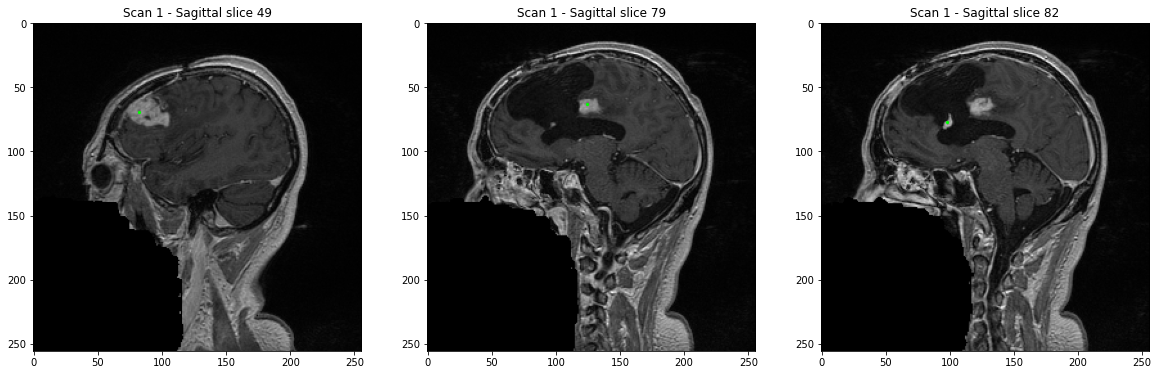

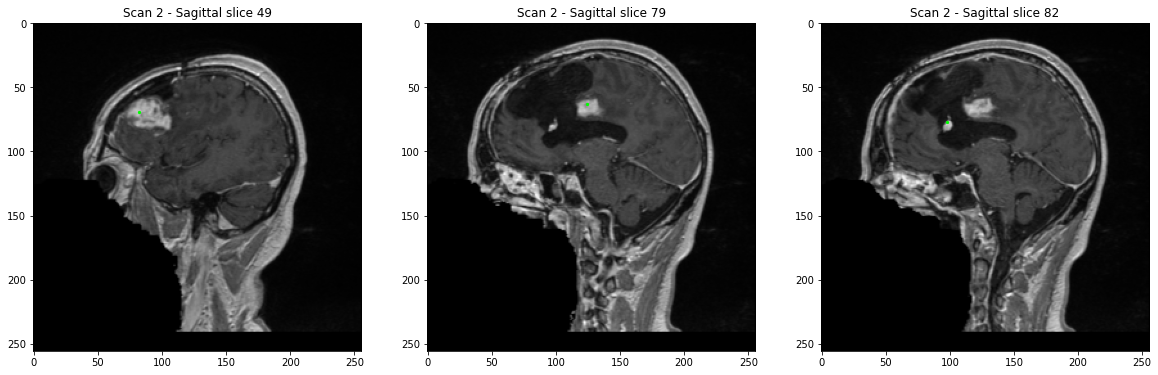

In [8]:
import matplotlib.pyplot as plt

print(scan2.shape)

plt.figure(figsize=(20, 10))

for i in range(3):
    point = tumor_points[i]
    plt.subplot(1, 3, i + 1)

    plt.title("Scan 1 - Sagittal slice " + str(point[2]))
    plt.scatter(point[0], point[1], color='lime', s=5)
    plt.imshow(scan1[point[2], :, :], cmap='gray')

plt.show()

plt.figure(figsize=(20, 10))

for i in range(3):
    point = tumor_points[i]
    plt.subplot(1, 3, i + 1)

    plt.title("Scan 2 - Sagittal slice " + str(point[2]))
    plt.scatter(point[0], point[1], color='lime', s=5)
    plt.imshow(scan2[point[2], :, :], cmap='gray')

plt.show()

In [39]:
segmentation1, segmentation2 = segmentData(scan1, scan2)

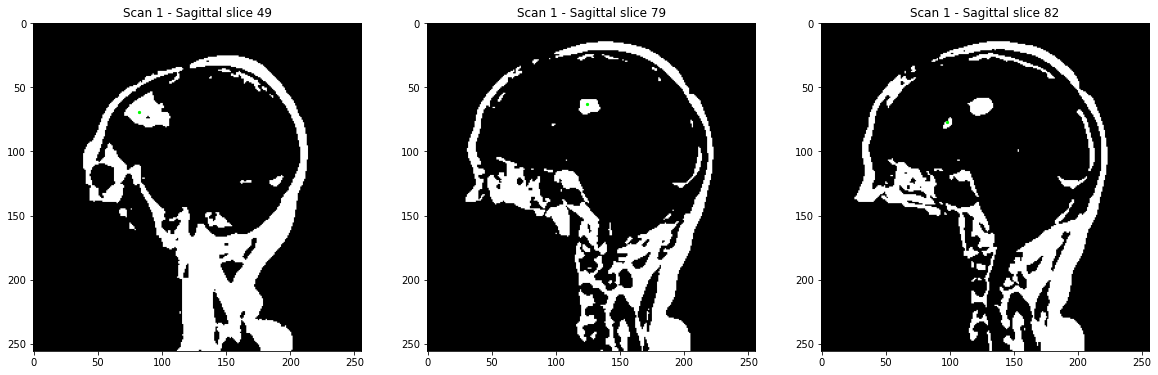

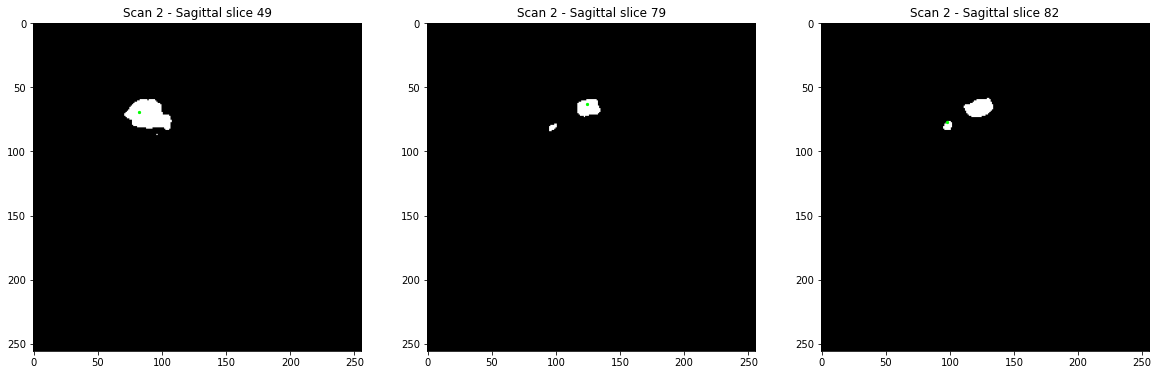

In [40]:
plt.figure(figsize=(20, 10))

for i in range(3):
    point = tumor_points[i]
    plt.subplot(1, 3, i + 1)

    plt.title("Scan 1 - Sagittal slice " + str(point[2]))
    plt.scatter(point[0], point[1], color='lime', s=5)
    plt.imshow(segmentation1[point[2], :, :], cmap='gray')

plt.show()

plt.figure(figsize=(20, 10))

for i in range(3):
    point = tumor_points[i]
    plt.subplot(1, 3, i + 1)

    plt.title("Scan 2 - Sagittal slice " + str(point[2]))
    plt.scatter(point[0], point[1], color='lime', s=5)
    plt.imshow(segmentation2[point[2], :, :], cmap='gray')

plt.show()

In [11]:
evolution = analyseData(segmentation1, segmentation2)

todo


In [12]:
visualizeData(evolution)

todo
